In [1]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.animation as anim
from numba import jit
import matplotlib.colors as mco
import seaborn as sns

In [2]:
mat = np.load(r"..\matrices\isolated-materials\float32\Transition1.npy")
img = mat[:,:,312]

(1085, 1085, 489)


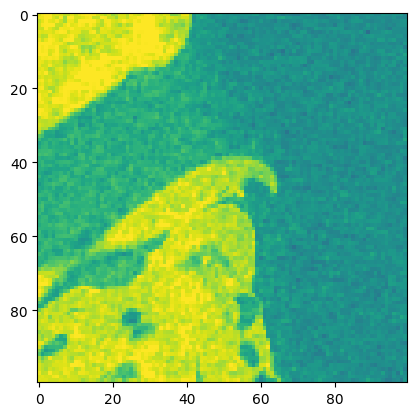

In [3]:
print(mat.shape)
plt.imshow(img[400:500, 980:1080], vmin=8000, vmax=12000)
plt.show()


Needs to accept seed locations of arbitrary amounts, keep track of which voxels are marked/unmarked, etc


In [40]:
# Testing 2D case
seeds = {(200,100,1),
         (100,1000,1),
         (1000,950,1),
         (1000,100,1),
         (882,806,2),
         (250,200,3),
         (353,899,3),
         (500,600,3),
         (950,450,2),
         (420,1030,1)}


bounds = [[0, 11627-431-1],
         [11627-431, 11627+431],
         [11902-445, 11902+445],
         [12329-567, 12329+567]]
# [0, 9500]
# [10020-393, 10020+393]

active = seeds
marked = np.zeros(img.shape, dtype=np.uint8)

# x, y, and m for material
for x,y,m in seeds:
    marked[x,y] = m

In [53]:
# Testing 3D case
seeds3D = {(200,100,312,1),
           (100,1000,312,1),
           (1000,950,312,1),
           (1000,100,312,1),
           (882,806,312,2),
           (250,200,312,3),
           (353,899,312,3),
           (500,600,312,3),
           (950,450,312,2),
           (420,1030,312,1)}

bounds = [[0, 11627-431-1],
         [11627-431, 11627+431],
         [11902-445, 11902+445],
         [12329-567, 12329+567]]

active3D = seeds3D.copy()
marked3D = np.zeros(mat.shape, dtype=np.uint8)

for x,y,z,m in seeds3D:
    marked3D[x,y,z] = m

In [6]:
## ALL WRONG LMAO
## Watershed region-growing, kept for later reference but currently useless.
## ADD NUMBA SET IMPLEMENTATION
## NJIT
## TRY GPU
def watershed_iterate_2D():
    for x,y,m,t in active.copy():
        if t>4:
            active.remove((x,y,m,t))
            continue
        
        x_coords = np.array([x-1,x+1,x,x], dtype=np.int32)
        y_coords = np.array([y,y,y-1,y+1], dtype=np.int32)

        vs = np.zeros(4, dtype=np.uint8)

        current = img[x,y]
        lower = bounds[m-1][0]
        upper = bounds[m-1][1]

        if x==0:
            vs[0] = 255
        if x==img.shape[0]-1:
            vs[1] = 255
        if y==0:
            vs[2] = 255
        if y==img.shape[1]-1:
            vs[3] = 255

        for n in range(4):
            if vs[n] != 255:
                vs[n] = marked[x_coords[n], y_coords[n]]

        minVal = 1e12
        index = 255
        for n in range(4):
            if vs[n] == 0:
                next = img[x_coords[n], y_coords[n]]
                val = np.abs(current-next) if lower<=next<=upper else minVal+1000
                if val < minVal:
                    minVal = val
                    index = n

        if index == 255:
            active.remove((x,y,m,t))
            continue
        else:
            marked[x_coords[index], y_coords[index]] = m
            active.add((x_coords[index], y_coords[index], m, 0))

        for n in range(4):
            if vs[n] != 255:
                vs[n] = marked[x_coords[n], y_coords[n]]

        if np.min(vs) > 0:
            active.remove((x,y,m,t))
        else:
            active.remove((x,y,m,t))
            active.add((x,y,m,t+1))
    

In [42]:
def region_grow_2D():
    for x,y,m in active.copy():
        x_coords = np.array([x-1,x+1,x,x], dtype=np.int32)
        y_coords = np.array([y,y,y-1,y+1], dtype=np.int32)

        vs = np.zeros(4, dtype=np.uint8)
        lower = bounds[m-1][0]
        upper = bounds[m-1][1]

        if x==0:vs[0]=255
        if x==mat.shape[0]-1:vs[1]=255
        if y==0:vs[2]=255
        if y==mat.shape[1]-1:vs[3]=255

        for n in range(4):
            if vs[n] != 255:
                vs[n] = marked[x_coords[n],y_coords[n]]
                if lower <= img[x_coords[n], y_coords[n]] <= upper and vs[n] == 0:
                    marked[x_coords[n], y_coords[n]] = m
                    active.add((x_coords[n], y_coords[n], m))
        
        active.remove((x,y,m))

In [54]:
def region_grow_3D():
    for x,y,z,m in active3D.copy():
        x_coords = np.array([x-1,x+1,x,x,x,x], dtype=np.int32)
        y_coords = np.array([y,y,y-1,y+1,y,y], dtype=np.int32)
        z_coords = np.array([z,z,z,z,z-1,z+1], dtype=np.int32)

        vs = np.zeros(6, dtype=np.uint8)
        lower = bounds[m-1][0]
        upper = bounds[m-1][1]

        if x==0:vs[0]=255
        if x==mat.shape[0]-1:vs[1]=255
        if y==0:vs[2]=255
        if y==mat.shape[1]-1:vs[3]=255
        if z==0:vs[4]=255
        if z==mat.shape[2]-1:vs[5]=255

        for n in range(6):
            if vs[n] != 255:
                vs[n] = marked3D[x_coords[n],y_coords[n],z_coords[n]]
                if lower <= mat[x_coords[n], y_coords[n], z_coords[n]] <= upper and vs[n] == 0:
                    marked3D[x_coords[n],y_coords[n],z_coords[n]] = m
                    active3D.add((x_coords[n], y_coords[n], z_coords[n], m))

        active3D.remove((x,y,z,m))

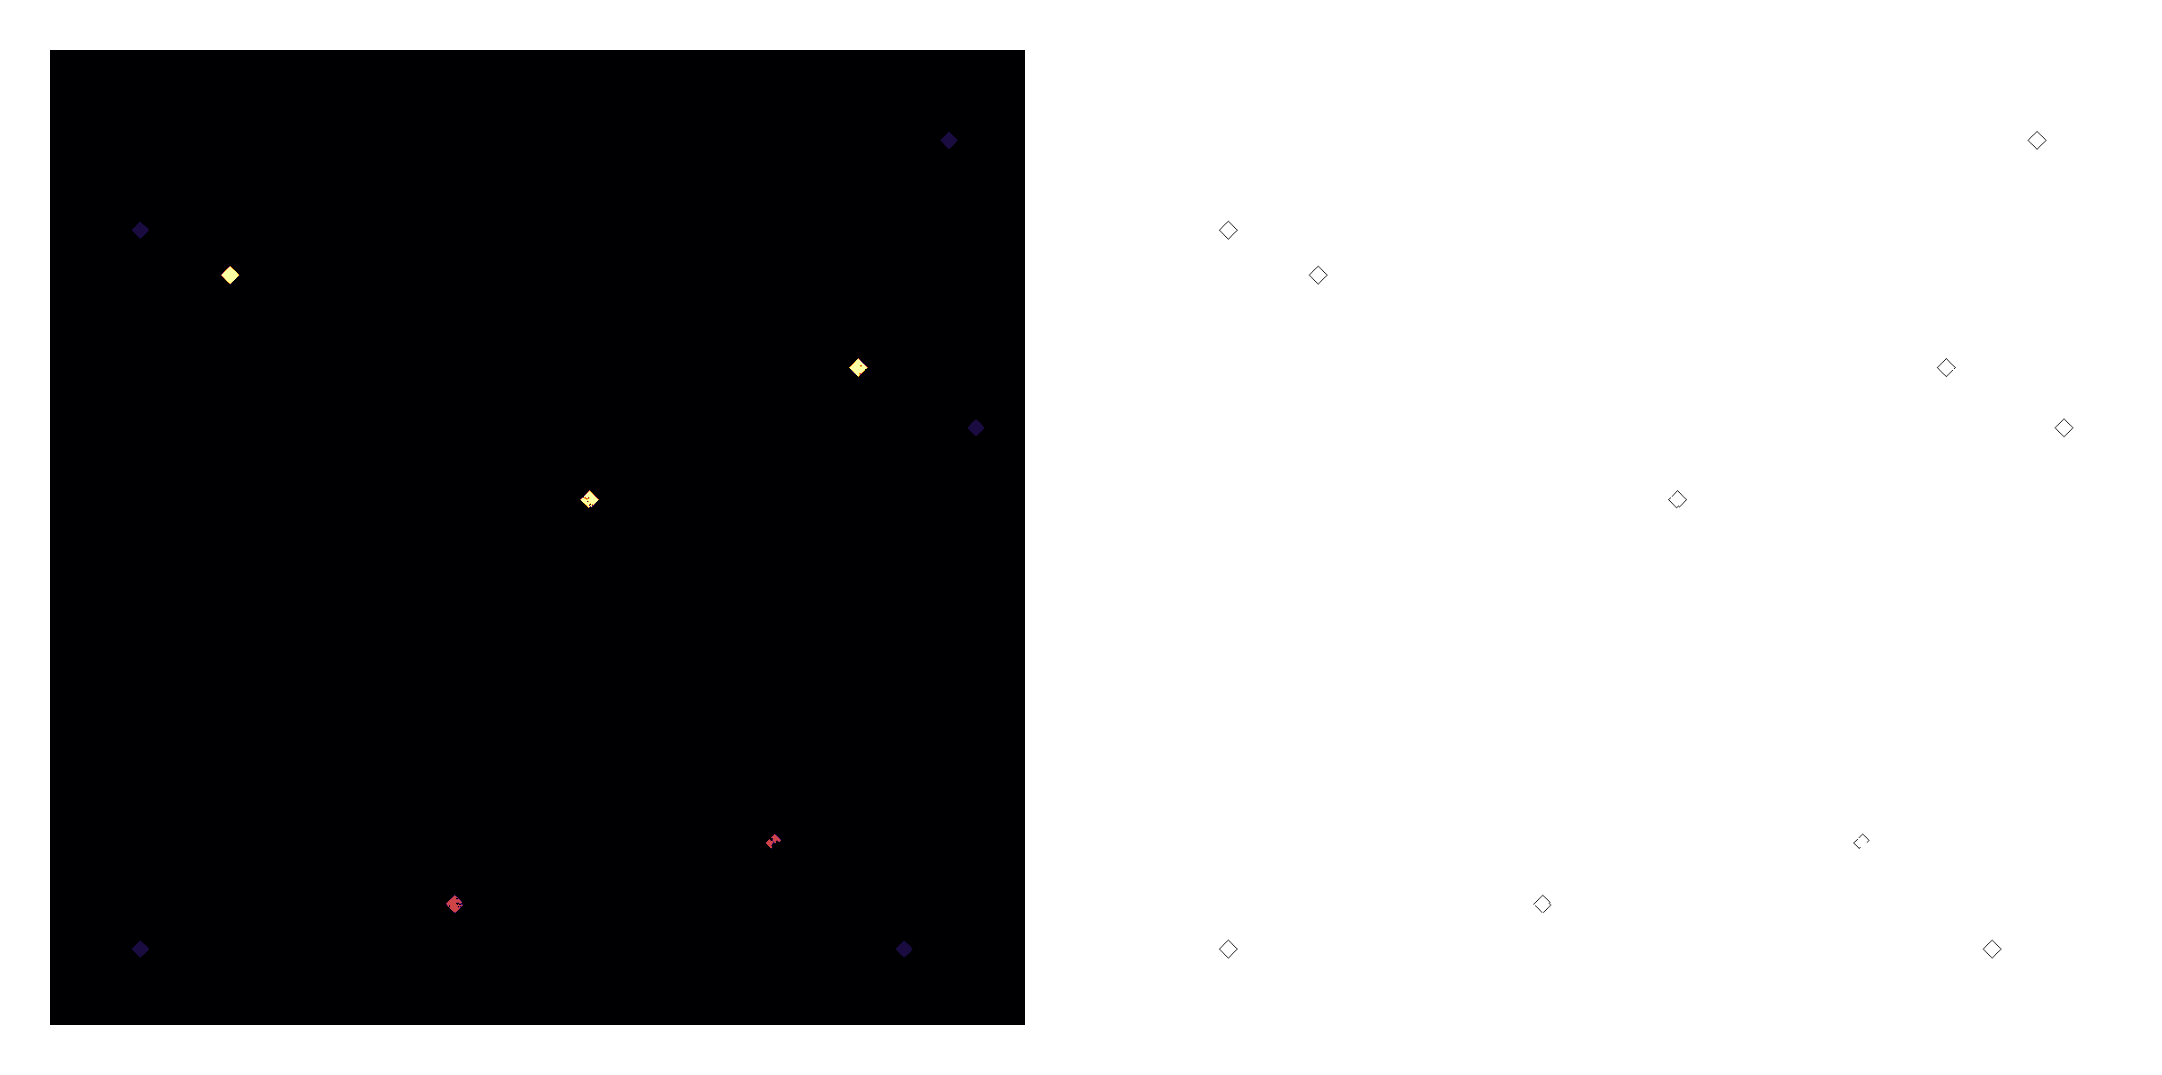

In [43]:
active_view = np.zeros(img.shape, np.bool_)
for x,y,_ in active:
    active_view[x,y] = 1

fig, axs = plt.subplots(1,2)
fig.set_size_inches(4.5,2.25,forward=True)
fig.set_dpi(500)
im0 = axs[0].imshow(marked, animated=True, cmap='inferno', vmin=0.75)
im1 = axs[1].imshow(active_view, animated=True, cmap='binary')
axs[0].axis(False)
axs[1].axis(False)

def update(_):
    for _ in range(5):
        region_grow_2D()

    active_view = np.zeros(img.shape, np.bool_)
    for x,y,_ in active:
        active_view[x,y] = 1
        
    im0.set_array(marked)
    im1.set_array(active_view)
    return im0,im1

anim_fig = anim.FuncAnimation(fig, update, frames=175, interval = 16.6667, blit=True)
plt.axis(False)
plt.tight_layout()
plt.show()

anim_fig.save("watershed3.gif")


In [57]:
n = 768
with tqdm(total=n) as pbar:
    for _ in range(n):
        region_grow_3D()
        pbar.update(1)

  0%|          | 0/768 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
active_view = np.zeros(img.shape, np.bool_)
for x,y,m in active:
    active_view[x,y] = 1

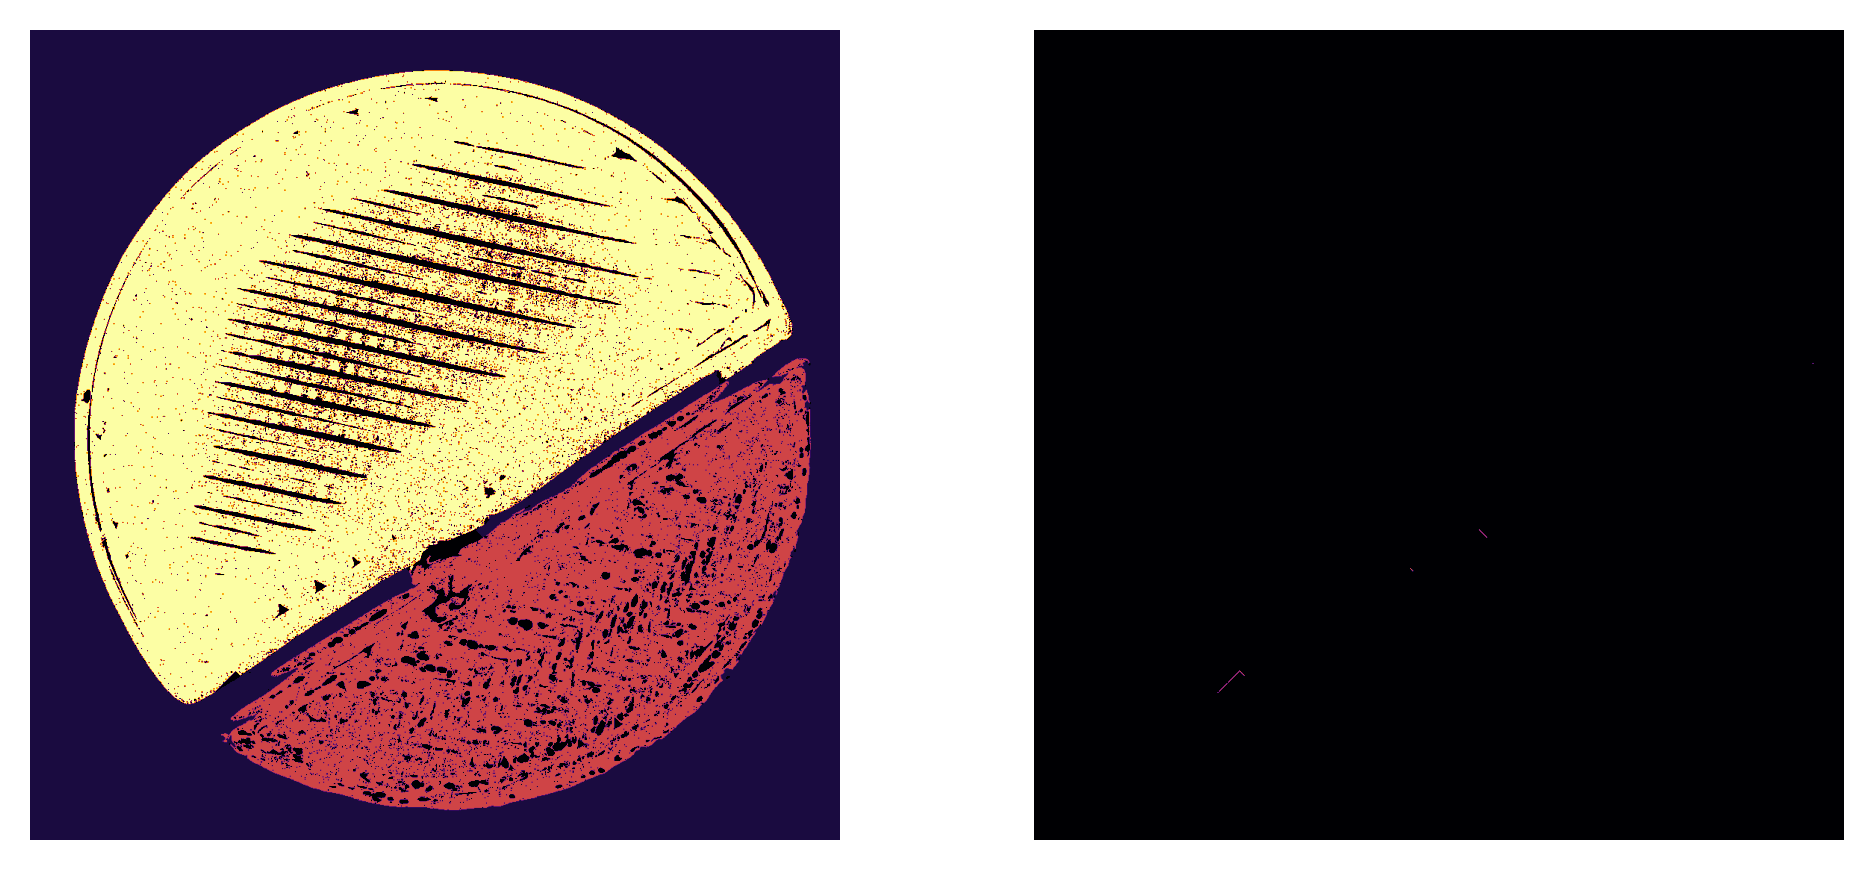

In [38]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(7,3)
fig.set_dpi(300)
axs[0].imshow(marked, cmap='inferno', vmin=0.75)
axs[1].imshow(active_view, cmap='inferno', vmax=1)
axs[0].axis(False)
axs[1].axis(False)
fig.tight_layout()
plt.show()

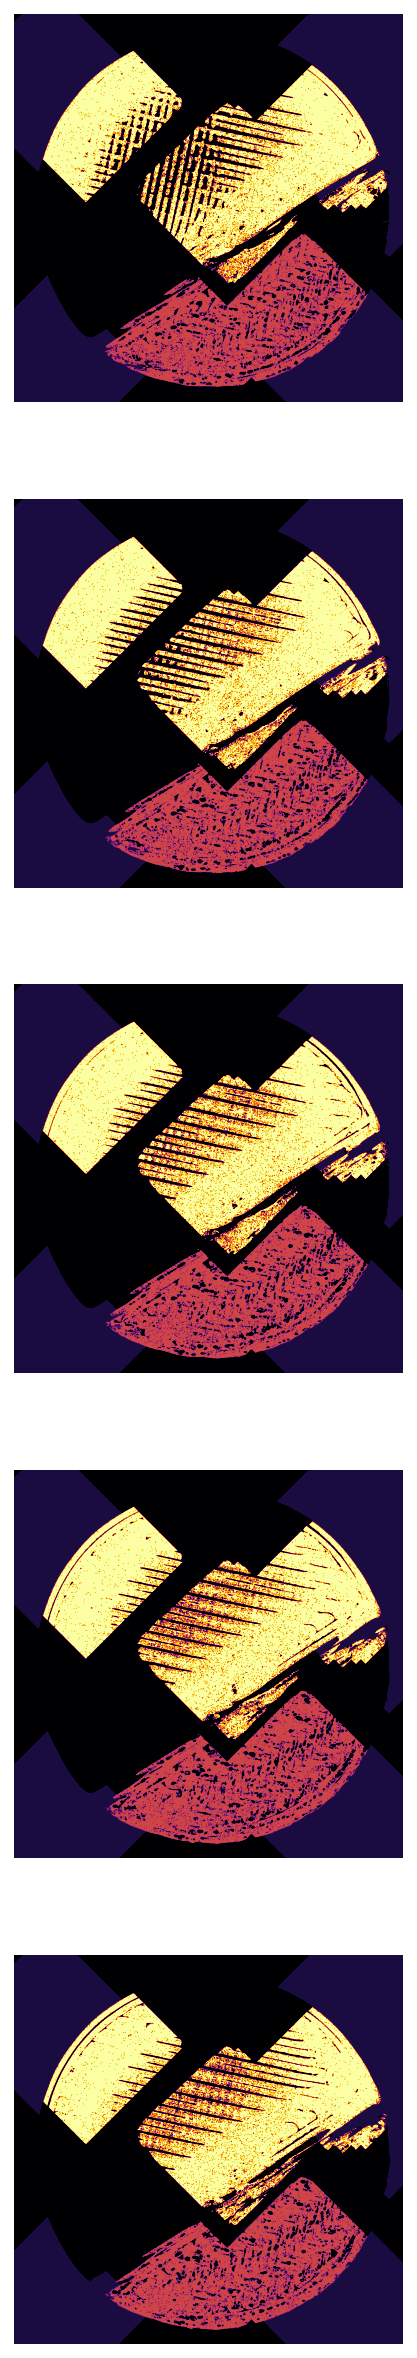

In [58]:
fig, axs = plt.subplots(5,1)
fig.set_size_inches(3,17)
fig.set_dpi(144)
axs[0].imshow(marked3D[:,:,310], cmap='inferno', vmin=0.75, vmax=3)
axs[1].imshow(marked3D[:,:,311], cmap='inferno', vmin=0.75, vmax=3)
axs[2].imshow(marked3D[:,:,312], cmap='inferno', vmin=0.75, vmax=3)
axs[3].imshow(marked3D[:,:,313], cmap='inferno', vmin=0.75, vmax=3)
axs[4].imshow(marked3D[:,:,314], cmap='inferno', vmin=0.75, vmax=3)
axs[0].axis(False)
axs[1].axis(False)
axs[2].axis(False)
axs[3].axis(False)
axs[4].axis(False)
fig.tight_layout()
plt.show()

In [59]:
import itk
import itkwidgets
volume = itk.GetImageFromArray(marked3D)